# Data Visualizations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
from glob import glob

def visualize_multiple_csvs_as_video(csv_folder, output_video_path='intersection.mp4', interval_ms=100, max_frames=None):
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

    if not all_csvs:
        print("No CSV files found.")
        return

    df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
    df = df.sort_values(by='TIMESTAMP')

    # Normalize track IDs to assign each car a unique color
    track_ids = df['TRACK_ID'].unique()
    colors = {track_id: plt.cm.tab20(i % 20) for i, track_id in enumerate(track_ids)}

    # Group by timestamp
    timestamps = sorted(df['TIMESTAMP'].unique())
    if max_frames is not None:
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
    ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
    ax.set_aspect('equal')

    def init():
        return []

    def update(frame_idx):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
        ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
        ax.set_title(f"Time: {ts:.1f}s")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')

        road_width = 50
        ax.add_patch(plt.Rectangle((df['X'].min() - 20, -road_width / 2),
                                (df['X'].max() - df['X'].min()) + 40,
                                road_width, color='lightgray', zorder=0))
        ax.add_patch(plt.Rectangle((-road_width / 2, df['Y'].min() - 20),
                                road_width,
                                (df['Y'].max() - df['Y'].min()) + 40,
                                color='lightgray', zorder=0))

        if ts not in grouped.groups:
            return []

        frame_df = grouped.get_group(ts)

        # Draw vehicles
        for _, row in frame_df.iterrows():
            x = float(row['X'])
            y = float(row['Y'])
            track_id = row['TRACK_ID']
            yaw_deg = float(row['yaw'])
            speed = float(row['speed'])
            color = colors.get(track_id, 'gray')

            # Heading for arrow (correct as is)
            heading_arrow = np.deg2rad(yaw_deg + 90)

            # Vehicle rotation (flipped horizontally)
            heading_rect = -heading_arrow

            length = 4
            width = 2
            dx = -length / 2
            dy = -width / 2

            rect = plt.Rectangle((x + dx, y + dy), length, width,
                                color=color, zorder=1)
            transform = plt.matplotlib.transforms.Affine2D().rotate_around(x, y, heading_rect) + ax.transData
            rect.set_transform(transform)
            ax.add_patch(rect)

            arrow_length = min(speed * 0.4, 10)
            ax.arrow(x, y,
                    -arrow_length * np.cos(heading_arrow),
                    arrow_length * np.sin(heading_arrow),
                    head_width=0.7,
                    head_length=1.0,
                    fc='black',
                    ec='black',
                    zorder=2)

            ax.text(x, y + 2.5, str(track_id), fontsize=6, ha='center', zorder=3)

        return []


    ani = animation.FuncAnimation(fig, update, frames=len(timestamps), init_func=init, interval=interval_ms, blit=False)
    ani.save(output_video_path, writer='ffmpeg', fps=1000 // interval_ms)
    print(f"Video saved to {output_video_path}")


Video saved to simple_separate_10m_intersection.mp4


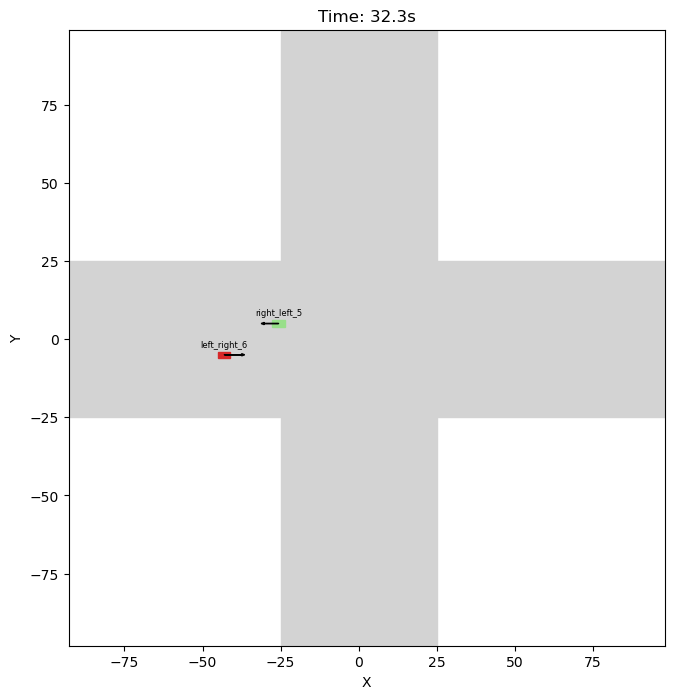

In [ ]:
path_to_csv_data = r'csv/train_1k_simple_separate_10m'
output_video_name = "simple_separate_10m_intersection.mp4"

visualize_multiple_csvs_as_video(
    csv_folder=path_to_csv_data,
    output_video_path=output_video_name,
    interval_ms=100,
    max_frames=250  # optional lenght of the video in frames (None for all frames)
)


## Test inference with the model and visualize

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os, math
from glob import glob
import torch
from model import GNN_mtl_gnn, GNN_mtl_mlp
from torch_geometric.data import Data
from tqdm import tqdm

/home/stud/vida/miniconda3/envs/MTP/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ──────────────────────────────
#  1.  helpers
# ─────────────────────────────
def rotation_matrix_back(yaw):
    """
    Turn model-space (forward = +x, left = +y)
    back into world space (matplotlib: +x right, +y up).

    Dataset yaw = 0 rad points north (+Y), so the world
    heading is (yaw + π/2).  Use that angle here.
    """
    angle = np.pi/2 + yaw          # << was  -π/2 + yaw
    rot = np.array([[np.cos(angle), -np.sin(angle)],
                    [np.sin(angle),  np.cos(angle)]])
    return torch.tensor(rot, dtype=torch.float32)

def build_data_for_track(track_rows, device):
    """
    track_rows: deque with dict-like rows.
    Creates Data.x  [num_vehicles, 7]  =  [X, Y, speed, yaw, int_left, int_right, int_straight]
    """
    # build intent flags from the first stored row
    tid = track_rows[0]['TRACK_ID']
    if 'left' in tid:
        intent = [1, 0, 0]
    elif 'right' in tid:
        intent = [0, 1, 0]
    else:
        intent = [0, 0, 1]

    feats = [[r['X'], r['Y'], r['speed'], r['yaw'], *intent] for r in track_rows]
    x = torch.tensor(feats, dtype=torch.float, device=device)
    edge_index = torch.empty((2, 0), dtype=torch.long, device=device)     # no graph edges here
    data = Data(x=x, edge_index=edge_index)
    # print(f"Data contains {data.x.shape[0]} frames for track {tid} with features: {data.x.shape[1]}")
    return data

def load_model(model_path, device, use_mlp=False, hidden_dim=128):
    """
    Load the model from the specified path.
    """
    cls = GNN_mtl_mlp if use_mlp else GNN_mtl_gnn
    model = cls(hidden_channels=hidden_dim).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model

def update_angle(yaw, p1, p2, p3):
    """
    Update the angle using the tangent of the curve defined by three points.
    yaw: Current yaw angle in radians.
    p1: First point (previous position)
    p2: Second point (current predicted position)
    p3: Third point (next predicted position)

    returns: Updated yaw angle in radians.
    """
    v0 = np.subtract(p2, p1)
    v1 = np.subtract(p3, p2)
    angle = np.arctan2(v1[1], v1[0]) - np.arctan2(v0[1], v0[0])
    new_yaw = np.mod(yaw + angle, 2*np.pi)   # wraps in one line
    return new_yaw

In [3]:
# car pointing north (yaw = 0), model predicts “drive 1 m forward”
local = np.array([1, 0])
world = rotation_matrix_back(0.).numpy() @ local
print(world)   # should be [0, 1]    

[6.12323426e-17 1.00000000e+00]


In [4]:
p1 = (0, 0)
p2 = (1, 0)     # heading east
p3 = (1, 1)     # turn north
print(np.rad2deg(update_angle(0, p1, p2, p3)))  # → 90°

90.0


In [5]:
# ──────────────────────────────
#  2.  main plotting function
# ──────────────────────────────

def visualize_with_prediction(
        csv_folder: str,
        model_path: str,
        output_video_path: str = 'simulation.mp4',
        device: str = 'cpu',
        interval_ms: int = 100,
        duration_sec: int = None,
        background_path: str = None,
        show_progress: bool = True):

    # ---------------- read data ----------------
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

    if not all_csvs:
        raise FileNotFoundError(f"No CSV files found in {csv_folder}")

    df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
    df = df.sort_values(by='TIMESTAMP')

    # Convert 'YAW' values from degrees to radians
    df['yaw'] = df['yaw'].apply(lambda x: np.deg2rad(x))

    timestamps = df['TIMESTAMP'].unique().tolist()
    if duration_sec is not None:
        max_frames = min(len(timestamps), int(duration_sec * 1000 / interval_ms))
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # ---------------- colours, limits ----------------
    track_ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i, tid in enumerate(track_ids)}

    x_lo, x_hi = df['X'].min() - 10, df['X'].max() + 10
    y_lo, y_hi = df['Y'].min() - 10, df['Y'].max() + 10

    # optional background
    bg_img = plt.imread(background_path) if background_path else None

    # ---------------- model ----------------
    model = load_model(model_path, device=device, use_mlp=False, hidden_dim=128)

    # ---------------- figure ----------------
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    last_track_position = dict()

    def init():
        return []

    def update(frame):
        # Set of track currently in the scene:

        ts = timestamps[frame]
        ax.clear()
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)
        ax.set_title(f'Time: {ts:.2f} s')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        if bg_img is not None:
            ax.imshow(bg_img, extent=[x_lo, x_hi, y_lo, y_hi],
                      origin='lower', cmap='gray', alpha=.6)

        else:
            road_width = 50
            ax.add_patch(plt.Rectangle((x_lo - 20, -road_width / 2),
                                    (x_hi - x_lo) + 40,
                                    road_width, color='lightgray', zorder=0))
            ax.add_patch(plt.Rectangle((-road_width / 2, y_lo - 20),
                                    road_width,
                                    (y_hi - y_lo) + 40,
                                    color='lightgray', zorder=0))

        frame_df = grouped.get_group(ts)

        for _, row in frame_df.iterrows():
            track_id = row['TRACK_ID']
            color = colours[track_id]

            # If the track is new in the current frame, take the data from the dataframe
            if track_id not in last_track_position:
                last_track_position[track_id] = row

                ax.plot(row['X'], row['Y'], 'o', color=color, label=f'Track {track_id}')
                ax.text(row['X'], row['Y'] + 2.5, str(track_id), fontsize=6, ha='center', zorder=3) # This line adds the track ID above the car

            # If the track is already shown, just update its position using the model's prediction
            else:
                prev_row = last_track_position[track_id]
                with torch.no_grad():
                    data = build_data_for_track([prev_row], device=device)
                    out = model(data.x[:, [0, 1, 4, 5, 6]], data.edge_index) # [x, y, v, yaw, intention(3-bit)] -> [x, y, intention], edge_index = [edge, 2]
                    out = out.reshape(-1,30,2)  # [v, pred, 2]
                    out = out.permute(0,2,1)    # [v, 2, pred]

                    # Rotate back to global coordinates
                    yaw = data.x[:,3].detach().cpu().numpy()
                    rotations = torch.stack([rotation_matrix_back(yaw[i])  for i in range(data.x.shape[0])]).to(out.device)
                    out = torch.bmm(rotations, out).permute(0,2,1)       # [v, pred, 2]
                    out += data.x[:,[0,1]].unsqueeze(1)

                    x_pred, y_pred = out[0, 0].tolist()
                    ax.plot(x_pred, y_pred, 'o', color=color, label=f'Track {track_id} (predicted)')

                    # PLot the future predictions but with transparent color
                    future_color = (color[0], color[1], color[2], 0.2)  # Make the color semi-transparent
                    ax.plot(out[0, 1:, 0].cpu().numpy(), out[0, 1:, 1].cpu().numpy(),
                            'o', color=future_color, label=f'Track {track_id} (future)', alpha=0.2)
                    
                    p1 = (prev_row['X'], prev_row['Y']) # p1 is the previous position in the track
                    p2 = (x_pred, y_pred) # p2 is the current position in the predictions
                    p3 = (out[0, 1, 0].item(), out[0, 1, 1].item()) # p3 is the next point in the predictions

                    new_yaw = update_angle(prev_row['yaw'], p1, p2, p3)

                    # draw arrow with new_yaw
                    ax.arrow(x_pred, y_pred, 5*np.cos(new_yaw), 5*np.sin(new_yaw),
                            head_width=2, head_length=2, fc=color, ec=color)
                    
                    # store the fresh state
                    last_track_position[track_id].update({'X': x_pred, 'Y': y_pred, 'yaw': new_yaw})

                    ax.text(x_pred, y_pred + 2.5, str(track_id), fontsize=6, ha='center', zorder=3) # This line adds the track ID above the car

        return []

    # ---------------- animation ----------------
    os.makedirs(os.path.dirname(output_video_path) or '.', exist_ok=True)

    ani = animation.FuncAnimation(
        fig, update, frames=len(timestamps),
        blit=False, interval=interval_ms, repeat=False)

    # ---------------- tqdm progress bar ----------------
    bar = tqdm(total=len(timestamps), disable=not show_progress,
               desc='Rendering frames')

    def _progress(frame_number, total):
        if frame_number > bar.n:
            bar.update(frame_number - bar.n)

    ani.save(output_video_path, writer='ffmpeg',
             fps=1000 // interval_ms, progress_callback=_progress)

    bar.close()
    print(f'Video saved to {output_video_path}')

Rendering frames: 100%|█████████▉| 199/200 [00:34<00:00,  5.76it/s]


Video saved to output/20250821_2042_animation_with_predictions_4.mp4


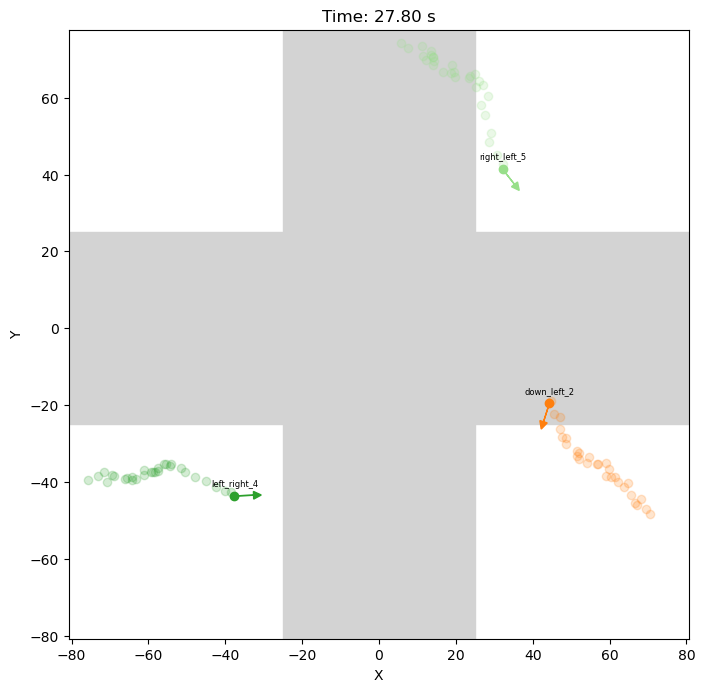

In [6]:
import datetime

# --- data and weights paths ---
csv_folder = 'csv/train_1k_x_separate_10m'
model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# bg_img_path = 'simple_separate_10m_binary.png'
output_video_path = f'output/{datetime.datetime.now().strftime("%Y%m%d_%H%M")}_animation_with_predictions_4.mp4'

visualize_with_prediction(
    csv_folder=csv_folder,
    model_path=model_path,
    output_video_path=output_video_path,
    device=device,
    interval_ms=100,
    duration_sec=20,
    background_path=None,
    show_progress=True
)

In [5]:
# --- data and weights paths ---
csv_folder = 'csv/train_1k_simple_separate_10m'
model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bg_img_path = 'simple_separate_10m_binary.png'
output_video_path = 'test' #'output/animation_with_predictions_4.mp4'

# ---------------- read data ----------------
all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

if not all_csvs:
    raise FileNotFoundError(f"No CSV files found in {csv_folder}")

df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
df = df.sort_values(by='TIMESTAMP')

timestamps = df['TIMESTAMP'].unique().tolist()

grouped = df.groupby('TIMESTAMP')

In [ ]:
import os, math
from glob import glob

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

# ──────────────────────────────
#  2.  main plotting function
# ──────────────────────────────
def visualize_with_prediction(
        csv_folder: str,
        model_path: str,
        output_video_path: str = 'simulation.mp4',
        device: str = 'cpu',
        interval_ms: int = 100,
        duration_sec: int = None,
        background_path: str = None,
        show_progress: bool = True):

    # ---------- read data ----------
    all_csvs = sorted(glob(os.path.join(csv_folder, '*.csv')))
    if not all_csvs:
        raise FileNotFoundError(f'No CSV files in {csv_folder}')

    df = (pd
          .concat(pd.read_csv(f) for f in all_csvs)
          .sort_values('TIMESTAMP'))

    timestamps = df['TIMESTAMP'].unique().tolist()
    if duration_sec is not None:
        max_frames = min(len(timestamps),
                         int(duration_sec * 1000 / interval_ms))
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # ---------- colours & limits ----------
    track_ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i, tid in enumerate(track_ids)}

    x_lo, x_hi = df['X'].min() - 10, df['X'].max() + 10
    y_lo, y_hi = df['Y'].min() - 10, df['Y'].max() + 10

    # ---------- background ----------
    bg_img = plt.imread(background_path) if background_path else None

    # ---------- model ----------
    model = GNN_mtl_gnn(hidden_channels=128).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ---------- figure ----------
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    last_track = {}          # track_id → last row (mutated in-place)

    # ---------- update function ----------
    def update(frame_idx: int):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)
        ax.set_title(f'Time: {ts:.2f} s')
        ax.set_xlabel('X'); ax.set_ylabel('Y')

        if bg_img is not None:
            ax.imshow(bg_img, extent=[x_lo, x_hi, y_lo, y_hi],
                      origin='lower', cmap='gray', alpha=.6)
        else:
            road_w = 50
            ax.add_patch(plt.Rectangle((x_lo - 20, -road_w/2),
                                       (x_hi - x_lo) + 40, road_w,
                                       color='lightgray', zorder=0))
            ax.add_patch(plt.Rectangle((-road_w/2, y_lo - 20),
                                       road_w, (y_hi - y_lo) + 40,
                                       color='lightgray', zorder=0))

        frame_df = grouped.get_group(ts)

        for _, now in frame_df.iterrows():
            tid   = now['TRACK_ID']
            color = colours[tid]

            # --- first time we see this car ---
            if tid not in last_track:
                last_track[tid] = now
                ax.plot(now['X'], now['Y'], 'o', color=color)
                ax.text(now['X'], now['Y']+2.5, tid, fontsize=6,
                        ha='center', zorder=3)
                continue

            # --- predict next position from model ---
            prev = last_track[tid]
            with torch.no_grad():
                data = build_data_for_track([prev], device=device)
                out  = model(data.x[:, [0, 1, 4, 5, 6]], data.edge_index)
                out  = (out.reshape(-1, 30, 2)
                            .permute(0, 2, 1))          # [1,2,30]

                yaw_rad = np.deg2rad(data.x[:, 3].cpu().numpy())
                R = torch.stack([rotation_matrix_back(a) for a in yaw_rad]
                                ).to(out.device)
                out = torch.bmm(R, out).permute(0, 2, 1)
                out += data.x[:, [0, 1]].unsqueeze(1)

                x_pred, y_pred = out[0, 0].tolist()

            # --- heading: direction of travel ---
            dx = x_pred - prev['X']
            dy = y_pred - prev['Y']
            yaw_next =  math.degrees(math.atan2(dy, dx) + yaw_rad[0])

            # --- draw & store ---
            ax.plot(x_pred, y_pred, 'o', color=color,
                    label=f'Track {tid} (pred)')
            ax.text(x_pred, y_pred + 2.5, tid, fontsize=6,
                    ha='center', zorder=3)

            new_row = prev.copy()
            new_row['X']   = x_pred
            new_row['Y']   = y_pred
            new_row['yaw'] = yaw_next
            last_track[tid] = new_row

        return []

    # ---------- animation ----------
    os.makedirs(os.path.dirname(output_video_path) or '.', exist_ok=True)

    ani = animation.FuncAnimation(
        fig, update, frames=len(timestamps),
        blit=False, interval=interval_ms, repeat=False)

    # ---------- tqdm ----------
    bar = tqdm(total=len(timestamps), disable=not show_progress,
               desc='Rendering frames')

    def _progress(frame_number, total):
        if frame_number > bar.n:
            bar.update(frame_number - bar.n)

    ani.save(output_video_path, writer='ffmpeg',
             fps=1000 // interval_ms, progress_callback=_progress)
    bar.close()
    print(f'Video saved to {output_video_path}')


Rendering frames: 100%|██████████| 350/350 [00:27<00:00, 12.72it/s]


Video saved to test.mp4


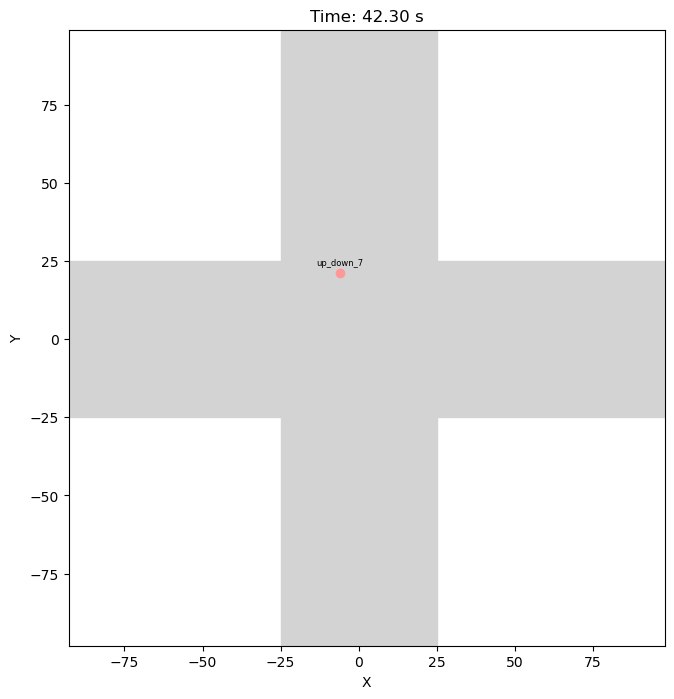

In [ ]:
# --- data and weights paths ---
csv_folder = 'csv/train_1k_simple_separate_10m'
model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bg_img_path = 'simple_separate_10m_binary.png'
output_video_path = 'output/test.mp4' # 'output/animation_with_predictions_4.mp4'

visualize_with_prediction(
    csv_folder=csv_folder,
    model_path=model_path,
    output_video_path=output_video_path,
    device=device,
    interval_ms=100,
    duration_sec=35,
    background_path=None,
    show_progress=True
)

render: 100%|█████████▉| 199/200 [00:19<00:00, 10.21it/s]


saved to output/20250823_1813_inclined_2_my_wg_anim.mp4


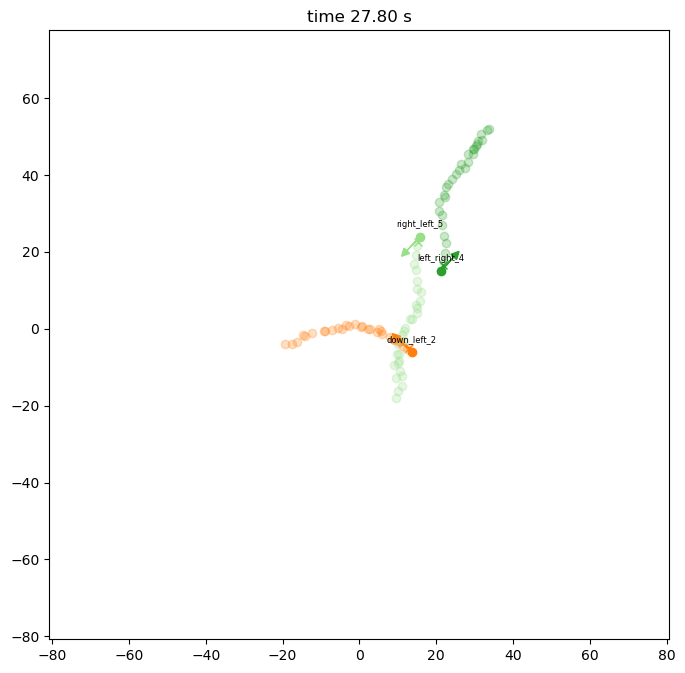

In [3]:
"""
visualize_with_prediction  –  local-Y-forward fix
-------------------------------------------------
Local vehicle frame:  +Y = forward, +X = left.
Rotation matrix columns swapped accordingly.
"""

import os, datetime
from pathlib import Path
from glob import glob
from model import GNN_mtl_gnn, GNN_mtl_mlp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch_geometric.data import Data
from tqdm import tqdm


# ───────────── helpers ─────────────

def ds_to_world_yaw(yaw_ds: float) -> float:
    """dataset yaw (0 = north)  →  world yaw (0 = east)."""
    return np.pi / 2 - yaw_ds

def rotation_matrix_back(yaw_ds: float) -> torch.Tensor:
    """
    Convert model offsets ( +Y forward, +X left )
    to world XY.  Columns: left-vector, forward-vector.
    """
    θ = ds_to_world_yaw(yaw_ds)
    rot = np.array([[-np.sin(θ),  np.cos(θ)],   # left
                    [ np.cos(θ),  np.sin(θ)]])  # forward
    return torch.tensor(rot, dtype=torch.float32)

def build_data_for_row(row, device):
    tid = row['TRACK_ID']
    intent = [1,0,0] if 'left' in tid else [0,1,0] if 'right' in tid else [0,0,1]
    feats = [[row['X'], row['Y'], row['speed'], row['yaw'], *intent]]
    x = torch.as_tensor(feats, dtype=torch.float32, device=device)
    ei = torch.empty((2,0), dtype=torch.long, device=device)
    return Data(x=x, edge_index=ei)


# ───────────── main ─────────────

def visualize_with_prediction(csv_folder,
                              model_path,
                              output_video_path='simulation.mp4',
                              device='cpu',
                              interval_ms=100,
                              duration_sec=None,
                              background_path=None,
                              show_progress=True,
                              debug=False):

    csvs = sorted(glob(os.path.join(csv_folder, '*.csv')))
    if not csvs:
        raise FileNotFoundError(f'No CSV files in {csv_folder}')

    df = (pd.concat(pd.read_csv(p) for p in csvs)
            .sort_values('TIMESTAMP'))
    df['yaw'] = np.deg2rad(df['yaw'])

    times = df['TIMESTAMP'].unique().tolist()
    if duration_sec:
        times = times[: int(duration_sec*1000/interval_ms)]

    grouped = df.groupby('TIMESTAMP')

    ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i,tid in enumerate(ids)}
    x_lo,x_hi = df['X'].min()-10, df['X'].max()+10
    y_lo,y_hi = df['Y'].min()-10, df['Y'].max()+10
    bg = plt.imread(background_path) if background_path else None

    model = GNN_mtl_gnn(hidden_channels=128).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    fig,ax = plt.subplots(figsize=(8,8)); ax.set_aspect('equal')

    def update(fi):
        ts = times[fi]
        frame = grouped.get_group(ts)

        ax.clear()
        ax.set_xlim(x_lo,x_hi); ax.set_ylim(y_lo,y_hi)
        ax.set_title(f'time {ts:.2f} s')

        if bg is not None:
            ax.imshow(bg, extent=[x_lo,x_hi,y_lo,y_hi],
                      origin='lower', cmap='gray', alpha=.6)

        for _, row in frame.iterrows():
            tid, col = row['TRACK_ID'], colours[row['TRACK_ID']]

            # ── 1-step prediction ────────────────────────────────
            data = build_data_for_row(row, device)
            with torch.no_grad():
                out = model(data.x[:,[0,1,4,5,6]], data.edge_index)
            out = out.reshape(-1,30,2).permute(0,2,1)

            rot = rotation_matrix_back(row['yaw']).to(out.device)
            out = torch.bmm(rot.unsqueeze(0), out).permute(0,2,1)
            out += data.x[:,[0,1]].unsqueeze(1)

            x_pred,y_pred = out[0,0].cpu().numpy()

            if debug:
                print(f'{tid:<12} ts={ts:5.2f}  '
                      f'real=({row["X"]:+6.2f},{row["Y"]:+6.2f})  '
                      f'pred=({x_pred:+6.2f},{y_pred:+6.2f})')

            # ── draw real position ───────────────────────────────
            ax.plot(row['X'], row['Y'], 'o', color=col)
            ax.text(row['X'], row['Y']+2.5, tid, fontsize=6, ha='center')

            world_yaw = ds_to_world_yaw(row['yaw'])
            ax.arrow(row['X'], row['Y'],
                     5*np.cos(world_yaw), 5*np.sin(world_yaw),
                     head_width=2, head_length=2, fc=col, ec=col)

            # one-step and future
            ax.plot(x_pred, y_pred, 'x', color=col)
            fut_col = (*col[:3], 0.25)
            ax.plot(out[0,1:,0].cpu(), out[0,1:,1].cpu(),
                    'o', color=fut_col, alpha=.25)

        return []

    Path(output_video_path).parent.mkdir(parents=True, exist_ok=True)
    ani = animation.FuncAnimation(fig, update, frames=len(times),
                                  blit=False, interval=interval_ms)

    bar = tqdm(total=len(times), disable=not show_progress, desc='render')
    ani.save(output_video_path, writer='ffmpeg',
             fps=1000//interval_ms,
             progress_callback=lambda f,t: bar.update(f-bar.n))
    bar.close()
    print('saved to', output_video_path)


# ───────────── example call ─────────────
if __name__ == '__main__':
    csv_folder = 'csv/train_1k_x_separate_10m'
    model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth' # Baseline model
    # model_path = 'trained_params/sumo_001/20250607_214504_simple_inclined_2_10m/model_gnn_np_sumo_001_e3_0130.pth'
    out_vid = f'output/{datetime.datetime.now():%Y%m%d_%H%M}_inclined_2_my_wg_anim.mp4'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    visualize_with_prediction(csv_folder,
                              model_path,
                              out_vid,
                              device=device,
                              interval_ms=100,
                              duration_sec=20,
                              background_path=None,
                              show_progress=True,
                              debug=False)


## Visualization of default gnn using predictions to move the vehicles

render: 100%|█████████▉| 199/200 [00:19<00:00, 10.42it/s]

saved to output/20250816_1756_pred-fed.mp4

--- quantitative results ---
average position error  : 40.515 m
average yaw error       : 1.527 rad
samples counted         : 384


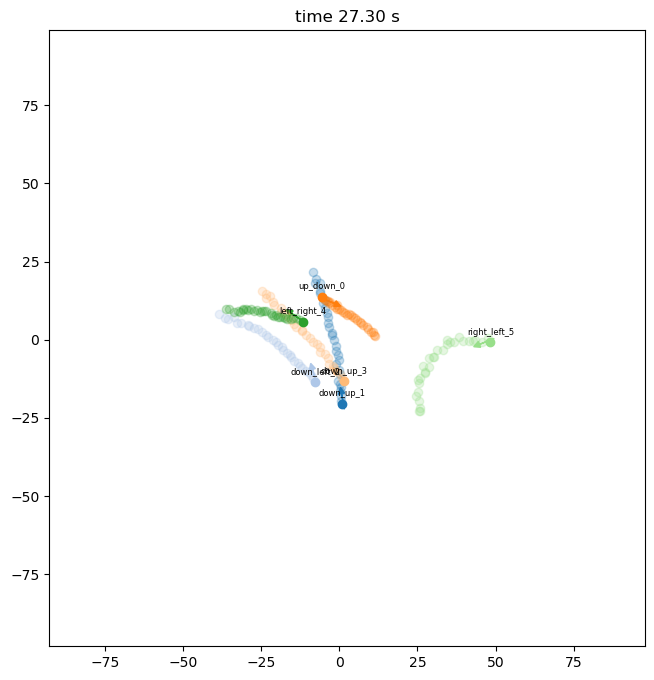

In [3]:
"""
visualize_with_prediction – prediction-fed version
--------------------------------------------------
* Local frame:  +Y = forward, +X = left            (unchanged)
* rotation_matrix_back uses that convention        (fixed earlier)
* After a track is spawned from CSV once, every
  next step starts from the *last predicted* state.
"""

import os, datetime
from pathlib import Path
from glob import glob
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from model import GNN_mtl_gnn, GNN_mtl_mlp
import torch
from torch_geometric.data import Data
from tqdm import tqdm


# ───────────── helpers ─────────────

def ds_to_world_yaw(yaw_ds: float) -> float:
    """dataset yaw (0 = north/+Y) → world yaw for matplotlib (0 = east/+X)."""
    return np.pi / 2 - yaw_ds

def rotation_matrix_back(yaw_ds: float) -> torch.Tensor:
    """
    Model offsets ( +Y forward, +X left ) → world XY.
    Columns are (left-vector, forward-vector).
    """
    θ = ds_to_world_yaw(yaw_ds)
    rot = np.array([[-np.sin(θ),  np.cos(θ)],    # left
                    [ np.cos(θ),  np.sin(θ)]])   # forward
    return torch.tensor(rot, dtype=torch.float32)

def compute_yaw_ds(p_old, p_new):
    """Absolute yaw in *dataset* convention from two world points."""
    dx, dy = np.subtract(p_new, p_old)
    return np.mod(np.pi/2 - np.arctan2(dy, dx), 2*np.pi)

def row_to_intent(tid: str):
    if 'left'  in tid: return [1,0,0]
    if 'right' in tid: return [0,1,0]
    return [0,0,1]

def build_data_from_state(state: dict, device):
    """Make a 1-frame PyG `Data` tensor from a plain dict."""
    x_vals = [[state['X'], state['Y'], state['speed'], state['yaw'],
               *row_to_intent(state['TRACK_ID'])]]
    x = torch.as_tensor(x_vals, dtype=torch.float32, device=device)
    ei = torch.empty((2,0), dtype=torch.long, device=device)
    return Data(x=x, edge_index=ei)


# ───────────── main ─────────────

def visualize_with_prediction(csv_folder,
                              model_path,
                              output_video_path='simulation.mp4',
                              device='cpu',
                              interval_ms=100,
                              duration_sec=None,
                              background_path=None,
                              show_progress=True,
                              debug=False):

    csvs = sorted(glob(os.path.join(csv_folder, '*.csv')))
    if not csvs:
        raise FileNotFoundError(f'No CSV files in {csv_folder}')

    df = (pd.concat(pd.read_csv(p) for p in csvs)
            .sort_values('TIMESTAMP'))
    df['yaw'] = np.deg2rad(df['yaw'])

    times = df['TIMESTAMP'].unique().tolist()
    if duration_sec:
        times = times[: int(duration_sec*1000/interval_ms)]

    grouped = df.groupby('TIMESTAMP')

    ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i,tid in enumerate(ids)}
    x_lo,x_hi = df['X'].min()-10, df['X'].max()+10
    y_lo,y_hi = df['Y'].min()-10, df['Y'].max()+10
    bg = plt.imread(background_path) if background_path else None

    model = GNN_mtl_gnn(hidden_channels=128).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    fig,ax = plt.subplots(figsize=(8,8)); ax.set_aspect('equal')

    # last predicted state for every trackID
    state = {}   # tid -> dict(X, Y, yaw, speed, TRACK_ID)
    
    metrics = {
        'pos_err': [],     # metres
        'yaw_err': []      # radians
    }

    def update(fi):
        ts = times[fi]
        frame_gt = grouped.get_group(ts)          # ground-truth rows in frame

        ax.clear()
        ax.set_xlim(x_lo,x_hi); ax.set_ylim(y_lo,y_hi)
        ax.set_title(f'time {ts:.2f} s')

        if bg is not None:
            ax.imshow(bg, extent=[x_lo,x_hi,y_lo,y_hi],
                      origin='lower', cmap='gray', alpha=.6)

        # ── spawn any NEW tracks from the CSV row in this frame ─────────
        for _, gt in frame_gt.iterrows():
            tid = gt['TRACK_ID']
            if tid not in state:
                state[tid] = {
                    'TRACK_ID': tid,
                    'X'       : gt['X'],
                    'Y'       : gt['Y'],
                    'yaw'     : gt['yaw'],
                    'speed'   : gt['speed']
                }
                if debug:
                    print(f'SPAWN {tid:<12} at '
                          f'({gt["X"]:+6.2f},{gt["Y"]:+6.2f}) yaw={gt["yaw"]:.2f}')

        # ── step every track that exists right now ──────────────────────
        next_state = {}

        for tid, prev in state.items():
            col = colours[tid]

            # ── model step from last predicted state ─────────────
            data = build_data_from_state(prev, device)
            with torch.no_grad():
                out = model(data.x[:, [0, 1, 4, 5, 6]], data.edge_index)
            out = out.reshape(-1, 30, 2).permute(0, 2, 1)

            rot = rotation_matrix_back(prev['yaw']).to(out.device)
            out = torch.bmm(rot.unsqueeze(0), out).permute(0, 2, 1)
            out += data.x[:, [0, 1]].unsqueeze(1)

            x_pred, y_pred = out[0, 0].cpu().numpy()

            # ── compare with ground-truth at next timestamp ──────
            if fi + 1 < len(times):
                ts_next = times[fi + 1]
                next_frame = grouped.get_group(ts_next)
                gt_next = next_frame[next_frame['TRACK_ID'] == tid]
                if not gt_next.empty:
                    gt_row = gt_next.iloc[0]
                    # position error
                    pos_err = np.hypot(x_pred - gt_row['X'],
                                       y_pred - gt_row['Y'])
                    metrics['pos_err'].append(pos_err)
                    # yaw error (wrap into [0,π])
                    yaw_pred = compute_yaw_ds((prev['X'], prev['Y']),
                                              (x_pred, y_pred))
                    dyaw = np.abs(np.mod(yaw_pred - gt_row['yaw'] + np.pi,
                                         2*np.pi) - np.pi)
                    metrics['yaw_err'].append(dyaw)

            # ── draw stuff (unchanged) ───────────────────────────
            ax.plot(x_pred, y_pred, 'o', color=col)
            ax.text(x_pred, y_pred + 2.5, tid, fontsize=6, ha='center')

            world_yaw = ds_to_world_yaw(prev['yaw'])
            ax.arrow(prev['X'], prev['Y'],
                     5*np.cos(world_yaw), 5*np.sin(world_yaw),
                     head_width=2, head_length=2, fc=col, ec=col)

            fut_col = (*col[:3], 0.25)
            ax.plot(out[0, 1:, 0].cpu(), out[0, 1:, 1].cpu(),
                    'o', color=fut_col, alpha=.25)

            # ── advance state ────────────────────────────────────
            yaw_ds_new = compute_yaw_ds((prev['X'], prev['Y']),
                                        (x_pred, y_pred))
            next_state[tid] = {
                'TRACK_ID': tid,
                'X': x_pred,
                'Y': y_pred,
                'yaw': yaw_ds_new,
                'speed': prev['speed']
            }


        # carry survivors forward
        state.clear()
        state.update(next_state)

        return []

    Path(output_video_path).parent.mkdir(parents=True, exist_ok=True)
    ani = animation.FuncAnimation(fig, update, frames=len(times),
                                  blit=False, interval=interval_ms)

    bar = tqdm(total=len(times), disable=not show_progress, desc='render')
    ani.save(output_video_path, writer='ffmpeg',
             fps=1000//interval_ms,
             progress_callback=lambda f,t: bar.update(f-bar.n))
    bar.close()
    print('saved to', output_video_path)

    # ── report metrics ───────────────────────────────────────────
    if metrics['pos_err']:
        print('\n--- quantitative results ---')
        print(f'average position error  : {np.mean(metrics["pos_err"]):.3f} m')
        print(f'average yaw error       : {np.mean(metrics["yaw_err"]):.3f} rad')
        print(f'samples counted         : {len(metrics["pos_err"])}')


# ───────────── example call ─────────────
if __name__ == '__main__':
    csv_folder = 'csv/train_1k_simple_separate_10m'
    model_path = ('trained_params_archive/sumo_with_mpc_online_control/'
                  'model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth')
    out_vid = f'output/{datetime.datetime.now():%Y%m%d_%H%M}_pred-fed.mp4'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    visualize_with_prediction(csv_folder,
                              model_path,
                              out_vid,
                              device=device,
                              interval_ms=100,
                              duration_sec=20,
                              background_path=None,
                              show_progress=True,
                              debug=False)   # flip to False for quiet run


Plot moving cars with GT and seeing the model predictions and next GT points, added metrics of distance and angle loss. Also model predicts for multiple cars at the time.

render: 100%|█████████▉| 999/1000 [02:02<00:00,  8.15it/s]


saved to output/20250823_1818_x_separate_10m_batch_anim.mp4

--- final averages ---
position error : 0.826 m
yaw error      : 0.550 rad
samples        : 3738


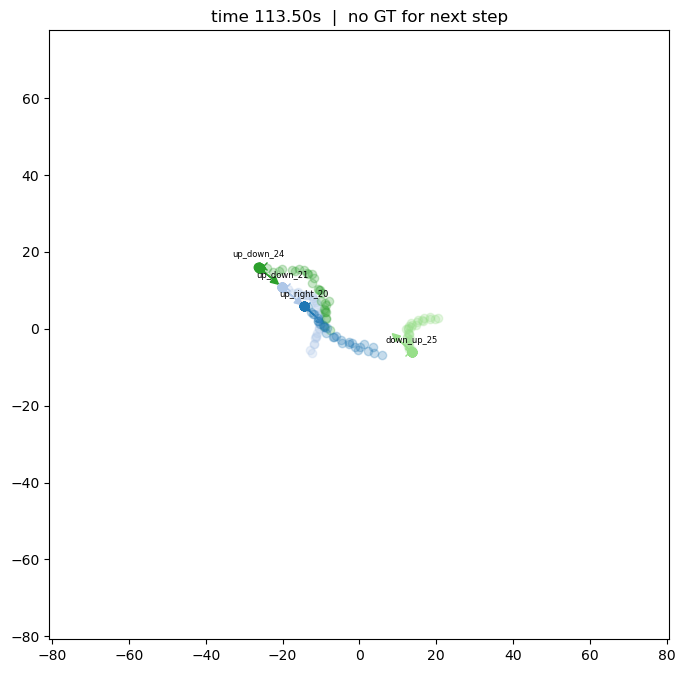

In [ ]:
"""
visualize_with_prediction – batched, with live metrics
------------------------------------------------------
Local frame: +Y forward, +X left  (matrix fixed).
"""

import os, datetime
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch_geometric.data import Data
from tqdm import tqdm
from model import GNN_mtl_gnn          # your model

# ───────────────── helpers ─────────────────

def ds_to_world_yaw(yaw_ds: np.ndarray) -> np.ndarray:
    """dataset yaw (0 = +Y) → world yaw (0 = +X)."""
    return np.pi/2 - yaw_ds

def rotation_matrix_back(yaw_ds: torch.Tensor) -> torch.Tensor:
    """
    Build B×2×2 matrix turning model offsets (+Y fwd, +X left) into world XY.
    yaw_ds is B-long vector (rad).
    """
    θ = ds_to_world_yaw(yaw_ds)
    sin, cos = torch.sin(θ), torch.cos(θ)
    # columns: left  (-sin, cos) , forward (cos, sin)
    return torch.stack([
        torch.stack([-sin,  cos], dim=1),
        torch.stack([ cos,  sin], dim=1)
    ], dim=1)                                   # [B, 2, 2]

def compute_yaw_ds(p_old, p_new):
    """Absolute yaw in *dataset* convention from two world points."""
    dx, dy = np.subtract(p_new, p_old)
    return np.mod(np.pi/2 - np.arctan2(dy, dx), 2*np.pi)

def row_to_intent(tid: str):
    if 'left'  in tid: return [1,0,0]
    if 'right' in tid: return [0,1,0]
    return [0,0,1]

def build_data_for_frame(frame_df: pd.DataFrame, device):
    """Return PyG Data with one node per row in frame_df."""
    feats = []
    for _, r in frame_df.iterrows():
        feats.append([r['X'], r['Y'], r['speed'], r['yaw'], *row_to_intent(r['TRACK_ID'])])
    x = torch.tensor(feats, dtype=torch.float32, device=device)
    edge_index = torch.empty((2,0), dtype=torch.long, device=device)   # no edges
    data = Data(x=x, edge_index=edge_index)
    return data

def get_future_xy(df, tid, ts, horizon_steps):
    """Return up to `horizon_steps` gt positions after timestamp ts for track tid."""
    sub = df[(df['TRACK_ID'] == tid) & (df['TIMESTAMP'] > ts)].sort_values('TIMESTAMP').head(horizon_steps)
    return sub[['X','Y']].to_numpy()

def wrap_angle(a):
    """|a|→[0,π]"""
    return np.abs((a + np.pi) % (2*np.pi) - np.pi)

# ───────────────── main ─────────────────

def visualize_with_prediction(csv_folder,
                              model_path,
                              output_video_path='simulation.mp4',
                              device='cpu',
                              interval_ms=100,
                              duration_sec=None,
                              background_path=None,
                              show_progress=True,
                              debug=False):

    # ===== read data
    csvs = sorted(glob(os.path.join(csv_folder, '*.csv')))
    if not csvs:
        raise FileNotFoundError(f'No CSV files in {csv_folder}')
    df = pd.concat(pd.read_csv(p) for p in csvs).sort_values('TIMESTAMP')
    df['yaw'] = np.deg2rad(df['yaw'])

    times = df['TIMESTAMP'].unique().tolist()
    if duration_sec:
        times = times[: int(duration_sec*1000/interval_ms)]
    grouped = df.groupby('TIMESTAMP')

    ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i,tid in enumerate(ids)}
    x_lo,x_hi = df['X'].min()-10, df['X'].max()+10
    y_lo,y_hi = df['Y'].min()-10, df['Y'].max()+10
    bg = plt.imread(background_path) if background_path else None

    # ===== model
    model = GNN_mtl_gnn(hidden_channels=128).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ===== fig
    fig, ax = plt.subplots(figsize=(8,8)); ax.set_aspect('equal')

    # ===== metrics
    pos_err_list, yaw_err_list = [], []

    def update(fi):
        ts = times[fi]
        frame = grouped.get_group(ts)

        # batch inference -------------------------------------------------
        data = build_data_for_frame(frame, device)
        with torch.no_grad():
            out = model(data.x[:, [0, 1, 4, 5, 6]], data.edge_index)
        B = out.size(0)
        out = out.view(B, 30, 2)
        rot = rotation_matrix_back(data.x[:, 3]).to(out.device)
        out = torch.bmm(rot, out.permute(0, 2, 1))      # B×2×30
        out = out.permute(0, 2, 1) + data.x[:, [0, 1]].unsqueeze(1)

        # clear canvas ----------------------------------------------------
        ax.clear()
        ax.set_xlim(x_lo, x_hi); ax.set_ylim(y_lo, y_hi)
        if bg is not None:
            ax.imshow(bg, extent=[x_lo, x_hi, y_lo, y_hi],
                      origin='lower', cmap='gray', alpha=.6)

        frame_pos_err, frame_yaw_err = [] , []   # <── per-frame holders

        # draw & measure --------------------------------------------------
        for idx, (_, row) in enumerate(frame.iterrows()):
            tid = row['TRACK_ID']; col = colours[tid]
            x_pred, y_pred = out[idx, 0].cpu().numpy()

            # real dot, arrow
            ax.plot(row['X'], row['Y'], 'o', color=col)
            ax.text(row['X'], row['Y'] + 2.5, tid, fontsize=6, ha='center')
            world_yaw = ds_to_world_yaw(row['yaw'])
            ax.arrow(row['X'], row['Y'],
                     5 * np.cos(world_yaw), 5 * np.sin(world_yaw),
                     head_width=2, head_length=2, fc=col, ec=col)

            # predicted dots
            ax.plot(x_pred, y_pred, 'x', color=col)
            fut_col = (*col[:3], 0.25)
            ax.plot(out[idx, 1:, 0].cpu(), out[idx, 1:, 1].cpu(),
                    'o', color=fut_col, alpha=.25)

            # GT future (hollow)
            gt_future = get_future_xy(df, tid, ts, 30)
            if gt_future.size:
                ax.plot(gt_future[:, 0], gt_future[:, 1],
                        'o', mfc='none', mec=col, alpha=.4)

            # metrics against NEXT timestamp
            if fi + 1 < len(times):
                next_rows = grouped.get_group(times[fi + 1])
                gt_next = next_rows[next_rows['TRACK_ID'] == tid]
                if not gt_next.empty:
                    gx, gy, gyaw = gt_next.iloc[0][['X', 'Y', 'yaw']]
                    pos_err = np.hypot(x_pred - gx, y_pred - gy)
                    yaw_pred = compute_yaw_ds((row['X'], row['Y']),
                                              (x_pred, y_pred))
                    yaw_err = wrap_angle(yaw_pred - gyaw)

                    # add to per-frame + global
                    frame_pos_err.append(pos_err)
                    frame_yaw_err.append(yaw_err)
                    pos_err_list.append(pos_err)
                    yaw_err_list.append(yaw_err)

        # title: **current frame mean** -----------------------------------
        if frame_pos_err:
            ax.set_title(f'time {ts:.2f}s  |  '
                         f'frame ⟨pos⟩ {np.mean(frame_pos_err):.2f} m  '
                         f'frame ⟨yaw⟩ {np.mean(frame_yaw_err):.2f} rad')
        else:
            ax.set_title(f'time {ts:.2f}s  |  no GT for next step')

        return []


    # ===== animate
    Path(output_video_path).parent.mkdir(parents=True, exist_ok=True)
    ani = animation.FuncAnimation(fig, update, frames=len(times),
                                  blit=False, interval=interval_ms)

    bar = tqdm(total=len(times), disable=not show_progress, desc='render')
    ani.save(output_video_path, writer='ffmpeg',
             fps=1000//interval_ms,
             progress_callback=lambda f,t: bar.update(f-bar.n))
    bar.close()
    print('saved to', output_video_path)
    if pos_err_list:
        print('\n--- final averages ---')
        print(f'position error : {np.mean(pos_err_list):.3f} m')
        print(f'yaw error      : {np.mean(yaw_err_list):.3f} rad')
        print(f'samples        : {len(pos_err_list)}')

# ───────────── example call ─────────────
if __name__ == '__main__':
    data = 'x_separate_10m'
    csv_folder = f'csv/train_1k_{data}'
    model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth' # Baseline model trained on default intersection
    # model_path = 'trained_params/sumo_001/20250607_214504_simple_inclined_2_10m/model_gnn_np_sumo_001_e3_0130.pth'
    out_vid = f'output/{datetime.datetime.now():%Y%m%d_%H%M}_{data}_batch_anim.mp4'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    visualize_with_prediction(csv_folder,
                              model_path,
                              out_vid,
                              device=device,
                              interval_ms=100,
                              duration_sec=100,
                              background_path=None,
                              show_progress=True,
                              debug=False)


## Visualization of predictions with the conditioned model using GT to move cars

In [1]:
# visualize_map_conditioned.py
"""
Video visualizer for the map-conditioned pipeline.
- One graph per frame, many agents (nodes).
- Uses the same feature convention as training:
  base_x = x[:, [0, 1, 4, 5, 6]]  -> [X, Y, int1, int2, int3]
  yaw is x[:, 3] and used only for the local->world rotation.
"""

import os
import argparse
from glob import glob
from pathlib import Path
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
from torch_geometric.data import Data

from PIL import Image
from torchvision import models, transforms
from torchvision.transforms import InterpolationMode


# ───────────────────────────────── Utils ─────────────────────────────────

def ds_to_world_yaw(yaw_ds: np.ndarray) -> np.ndarray:
    """Dataset yaw (0 = +Y) → world yaw (0 = +X)."""
    return np.pi/2 - yaw_ds

def rotation_matrix_back_tensor(yaw_ds: torch.Tensor) -> torch.Tensor:
    """
    Build B×2×2 matrix turning model offsets (+Y fwd, +X left) into world XY.
    yaw_ds is B-long vector (rad).
    """
    theta = ds_to_world_yaw(yaw_ds)
    sin, cos = torch.sin(theta), torch.cos(theta)
    # columns: left  (-sin, cos) , forward (cos, sin)
    return torch.stack([
        torch.stack([-sin,  cos], dim=1),
        torch.stack([ cos,  sin], dim=1)
    ], dim=1)  # [B,2,2]

def compute_yaw_ds(p_old, p_new):
    """Absolute yaw in dataset convention from two world points."""
    dx, dy = np.subtract(p_new, p_old)
    return np.mod(np.pi/2 - np.arctan2(dy, dx), 2*np.pi)

def wrap_angle(a):
    """|a|→[0,π]"""
    return np.abs((a + np.pi) % (2*np.pi) - np.pi)

def row_to_intent(tid: str):
    # Tweak if you have a better intent label source in your CSVs
    if isinstance(tid, str):
        if 'left'  in tid: return [1,0,0]
        if 'right' in tid: return [0,1,0]
    return [0,0,1]

def build_data_for_frame(frame_df: pd.DataFrame, device):
    """
    Create a PyG Data with one node per actor.
    Columns expected in df: X, Y, speed, yaw (deg or rad? we’ll convert to rad below)
    """
    feats = []
    for _, r in frame_df.iterrows():
        feats.append([r['X'], r['Y'], r['speed'], r['yaw'], *row_to_intent(r['TRACK_ID'])])
    x = torch.tensor(feats, dtype=torch.float32, device=device)  # [N, 7]
    edge_index = torch.empty((2, 0), dtype=torch.long, device=device)  # no edges (GraphConv adds self-loops)
    return Data(x=x, edge_index=edge_index)

def get_future_xy(df, tid, ts, horizon_steps):
    """Return up to `horizon_steps` gt positions after timestamp ts for track tid."""
    sub = df[(df['TRACK_ID'] == tid) & (df['TIMESTAMP'] > ts)].sort_values('TIMESTAMP').head(horizon_steps)
    return sub[['X','Y']].to_numpy()

def load_background(background_path, x_lo, x_hi, y_lo, y_hi):
    if not background_path:
        return None
    try:
        bg = plt.imread(background_path)
        return (bg, [x_lo, x_hi, y_lo, y_hi])
    except Exception:
        return None

def build_image_cache_single(image_dir: str, map_key: str, img_size: int = 224):
    tfm = transforms.Compose([
        transforms.Resize((img_size, img_size), interpolation=InterpolationMode.NEAREST),
        transforms.ToTensor(),
    ])
    # try <key>_binary.png then <key>.png
    candidates = [
        os.path.join(image_dir, f"{map_key}_binary.png"),
        os.path.join(image_dir, f"{map_key}.png"),
    ]
    p = None
    for c in candidates:
        if os.path.exists(c):
            p = c; break
    if p is None:
        print(f"[warn] map image not found for key '{map_key}', using zeros")
        return torch.zeros(3, img_size, img_size)

    img = Image.open(p).convert("RGB")
    return tfm(img)  # [3,H,W]


# ─────────────────────────────── Model (same as training) ───────────────────────────────

class ResNetMapEncoder(nn.Module):
    def __init__(self, z_dim: int = 128, finetune: bool = False):
        super().__init__()
        # Support both new and old torchvision
        try:
            m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        except Exception:
            m = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(m.children())[:-1])  # [B,512,1,1]
        self.out_dim = 512
        self.proj = nn.Identity() if (z_dim is None or z_dim == self.out_dim) else nn.Linear(self.out_dim, z_dim)
        self.freeze = not finetune
        if self.freeze:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, img_bchw: torch.Tensor) -> torch.Tensor:
        if self.freeze:
            self.backbone.eval()
            with torch.no_grad():
                f = self.backbone(img_bchw)
        else:
            f = self.backbone(img_bchw)
        return self.proj(f.flatten(1))  # [B, z]

class GNN_mtl_gnn_map(nn.Module):
    def __init__(self, hidden_channels: int, in_dim: int):
        super().__init__()
        from torch_geometric.nn import GraphConv
        self.conv1 = GraphConv(hidden_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.linear1 = nn.Linear(in_dim, 64)
        self.linear2 = nn.Linear(64, hidden_channels)
        self.linear3 = nn.Linear(hidden_channels, hidden_channels)
        self.linear4 = nn.Linear(hidden_channels, hidden_channels)
        self.linear5 = nn.Linear(hidden_channels, 30 * 2)

    def forward(self, x, edge_index):
        x = self.linear1(x).relu()
        x = self.linear2(x).relu()
        x = self.linear3(x).relu() + x
        x = self.linear4(x).relu() + x
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.linear5(x)

class GNN_mtl_mlp_map(nn.Module):
    def __init__(self, hidden_channels: int, in_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.fc2 = nn.Linear(64, hidden_channels)
        self.fc3 = nn.Linear(hidden_channels, hidden_channels)
        self.fc4 = nn.Linear(hidden_channels, hidden_channels)
        self.out = nn.Linear(hidden_channels, 30 * 2)

    def forward(self, x, edge_index=None):
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x).relu() + x
        x = self.fc4(x).relu() + x
        return self.out(x)

class MapConditionedModel(nn.Module):
    def __init__(self, base_in_dim: int, z_dim: int, hidden: int, use_gnn: bool, finetune_encoder: bool):
        super().__init__()
        self.map_encoder = ResNetMapEncoder(z_dim=z_dim, finetune=finetune_encoder)
        in_dim = base_in_dim + (z_dim if z_dim is not None else self.map_encoder.out_dim)
        self.core = GNN_mtl_gnn_map(hidden, in_dim) if use_gnn else GNN_mtl_mlp_map(hidden, in_dim)


# ─────────────────────────────── Visualizer ───────────────────────────────

def visualize_with_prediction_map(
    csv_folder: str,
    model_path: str,
    image_dir: str,
    map_key: str,
    use_gnn: bool,
    hidden: int,
    z_dim: int,
    finetune_encoder: bool,
    output_video_path='simulation.mp4',
    device='cpu',
    interval_ms=100,
    duration_sec=None,
    background_path=None,
    show_progress=True,
):
    # ----- load CSVs -----
    csvs = sorted(glob(os.path.join(csv_folder, '*.csv')))
    if not csvs:
        raise FileNotFoundError(f'No CSV files in {csv_folder}')
    df = pd.concat(pd.read_csv(p) for p in csvs).sort_values('TIMESTAMP')

    # ensure yaw is radians
    if df['yaw'].abs().max() > 3.2:   # likely degrees
        df['yaw'] = np.deg2rad(df['yaw'])

    times = df['TIMESTAMP'].unique().tolist()
    if duration_sec:
        times = times[: int(duration_sec*1000/interval_ms)]
    grouped = df.groupby('TIMESTAMP')

    ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i, tid in enumerate(ids)}
    x_lo,x_hi = df['X'].min()-10, df['X'].max()+10
    y_lo,y_hi = df['Y'].min()-10, df['Y'].max()+10
    bg = load_background(background_path, x_lo, x_hi, y_lo, y_hi)

    # ----- model -----
    model = MapConditionedModel(
        base_in_dim=5,
        z_dim=z_dim,
        hidden=hidden,
        use_gnn=use_gnn,
        finetune_encoder=finetune_encoder
    ).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    # map embedding: precompute once
    img = build_image_cache_single(image_dir, map_key, img_size=224).unsqueeze(0).to(device)  # [1,3,H,W]
    with torch.no_grad():
        z_graph = model.map_encoder(img)   # [1, z]
    z_graph = z_graph.squeeze(0)           # [z]

    # ----- fig -----
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_aspect('equal')

    # metrics across frames
    pos_err_list, yaw_err_list = [], []

    def update(fi):
        ts = times[fi]
        frame = grouped.get_group(ts).reset_index(drop=True)

        # build graph for this frame
        data = build_data_for_frame(frame, device)  # x: [N,7]
        N = data.x.size(0)

        # base features + broadcast z to nodes
        base_x = data.x[:, [0, 1, 4, 5, 6]]               # [N,5]
        z_nodes = z_graph.unsqueeze(0).expand(N, -1)      # [N,z]
        x_in = torch.cat([base_x, z_nodes], dim=1)

        # forward core
        with torch.no_grad():
            out = model.core(x_in, data.edge_index)       # [N, 30*2]

        # local->world and absolute XY
        out = out.view(N, 30, 2).permute(0, 2, 1)         # N×2×30
        R = rotation_matrix_back_tensor(data.x[:, 3])     # N×2×2
        out = torch.bmm(R, out).permute(0, 2, 1)          # N×30×2
        out = out + data.x[:, [0, 1]].unsqueeze(1)        # add current XY

        # clear canvas
        ax.clear()
        ax.set_xlim(x_lo, x_hi); ax.set_ylim(y_lo, y_hi)
        if bg is not None:
            bg_img, ext = bg
            ax.imshow(bg_img, extent=ext, origin='lower', cmap='gray', alpha=.6)

        # per-frame metrics
        frame_pos_err, frame_yaw_err = [], []

        # draw
        for i in range(N):
            row = frame.iloc[i]
            tid = row['TRACK_ID']; col = colours[tid]
            # current real
            ax.plot(row['X'], row['Y'], 'o', color=col, markersize=4)
            ax.text(row['X'], row['Y'] + 2.5, str(tid), fontsize=6, ha='center')

            world_yaw = ds_to_world_yaw(row['yaw'])
            ax.arrow(row['X'], row['Y'],
                     5*np.cos(world_yaw), 5*np.sin(world_yaw),
                     head_width=2, head_length=2, fc=col, ec=col)

            # predictions
            x_pred, y_pred = out[i, 0].cpu().numpy()
            ax.plot(x_pred, y_pred, 'x', color=col)
            fut_col = (*col[:3], 0.25)
            ax.plot(out[i, 1:, 0].cpu(), out[i, 1:, 1].cpu(), 'o', color=fut_col, alpha=.25, markersize=3)

            # GT future as hollow
            gt_future = get_future_xy(df, tid, ts, 30)
            if gt_future.size:
                ax.plot(gt_future[:, 0], gt_future[:, 1], 'o', mfc='none', mec=col, alpha=.4, markersize=3)

            # next-step metrics
            if fi + 1 < len(times):
                next_rows = grouped.get_group(times[fi + 1])
                gt_next = next_rows[next_rows['TRACK_ID'] == tid]
                if not gt_next.empty:
                    gx, gy, gyaw = gt_next.iloc[0][['X', 'Y', 'yaw']]
                    pos_err = float(np.hypot(x_pred - gx, y_pred - gy))
                    yaw_pred = compute_yaw_ds((row['X'], row['Y']), (x_pred, y_pred))
                    yaw_err = float(wrap_angle(yaw_pred - gyaw))
                    frame_pos_err.append(pos_err); pos_err_list.append(pos_err)
                    frame_yaw_err.append(yaw_err); yaw_err_list.append(yaw_err)

        if frame_pos_err:
            ax.set_title(f'time {ts:.2f}s  |  '
                         f'frame ⟨pos⟩ {np.mean(frame_pos_err):.2f} m  '
                         f'frame ⟨yaw⟩ {np.mean(frame_yaw_err):.2f} rad')
        else:
            ax.set_title(f'time {ts:.2f}s  |  no GT for next step')

        return []

    # animate
    Path(output_video_path).parent.mkdir(parents=True, exist_ok=True)
    ani = animation.FuncAnimation(fig, update, frames=len(times), blit=False, interval=interval_ms)
    ani.save(output_video_path, writer='ffmpeg', fps=max(1, 1000//interval_ms))
    print('saved to', output_video_path)
    if pos_err_list:
        print('\n--- final averages ---')
        print(f'position error : {np.mean(pos_err_list):.3f} m')
        print(f'yaw error      : {np.mean(yaw_err_list):.3f} rad')
        print(f'samples        : {len(pos_err_list)}')



/home/stud/vida/miniconda3/envs/MTP/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


saved to output/20250910_2022_map_cond.mp4

--- final averages ---
position error : 20.295 m
yaw error      : 1.865 rad
samples        : 55602


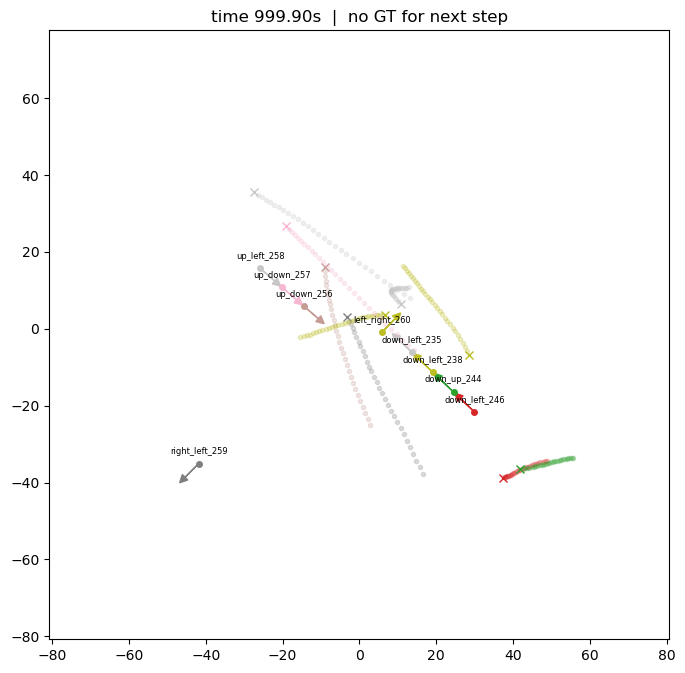

In [2]:

csv_folder = 'csv/train_1k_x_separate_10m'
# model_path = 'trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth' # Baseline model trained on default intersection
model_path = 'trained_params/with_map_resnet/20250822_014130/model_best.pth'
image_dir = "map_binary_images"
map_key = 'x_separate_10m'
out_vid = f'output/{datetime.datetime.now():%Y%m%d_%H%M}_map_cond.mp4'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_gnn = True
hidden = 128
z_dim = 128
finetune_encoder = False

visualize_with_prediction_map(
    csv_folder=csv_folder,
    model_path=model_path,
    image_dir=image_dir,
    map_key=map_key,
    use_gnn=use_gnn,
    hidden=hidden,
    z_dim=z_dim,
    finetune_encoder=finetune_encoder,
    output_video_path=out_vid,
    device=device,
    interval_ms=100,
    duration_sec=None,
    background_path=None,
    show_progress=False,
)

# Visualization of my own transformer architecture:

/home/stud/vida/miniconda3/envs/MTP/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Rendering video: 100%|█████████▉| 299/300 [00:35<00:00,  8.54it/s]



Video saved to: output/simple_separate_10m/20250816_1828_simple_separate_10m_transformer_anim.mp4

--- Final Average Metrics (1-step prediction) ---
Position Error : 6.148 m
Yaw Error      : 82.225 degrees
Total Samples  : 15840


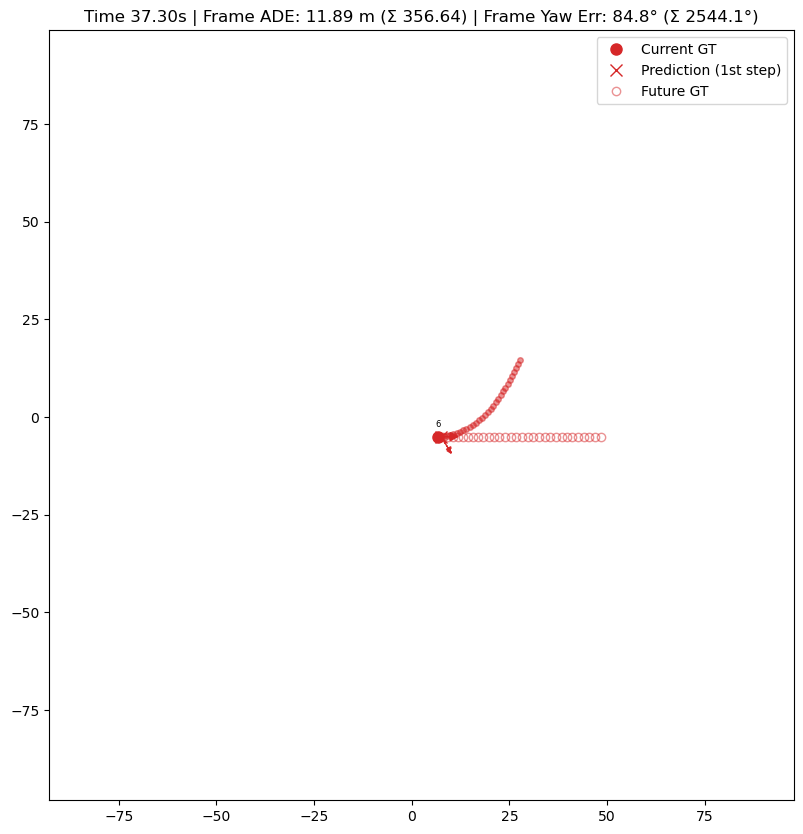

In [1]:
# visualize_transformer.py (FIXED HORIZONTAL FLIP)

import os
import datetime
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch_geometric.data import Data
from tqdm import tqdm
from transformer_model import GraphTransformer

# ───────────────── helpers ─────────────────

def ds_to_world_yaw(yaw_ds: np.ndarray) -> np.ndarray:
    """Dataset yaw (0 rad = +Y) → world yaw (0 rad = +X) for plotting arrows."""
    return np.pi / 2.0 - yaw_ds

def row_to_intent(tid: str):
    """Encodes intention from track ID."""
    if 'left'  in tid: return [1,0,0]
    if 'right' in tid: return [0,1,0]
    return [0,0,1]

def build_data_for_frame(frame_df: pd.DataFrame, device):
    """Return PyG Data with one node per row in frame_df for the Transformer."""
    feats = []
    for _, r in frame_df.iterrows():
        feats.append([r['X'], r['Y'], r['yaw'], *row_to_intent(r['TRACK_ID'])])
    
    x = torch.tensor(feats, dtype=torch.float32, device=device)
    edge_index = torch.empty((2,0), dtype=torch.long, device=device)
    data = Data(x=x, edge_index=edge_index)
    return data

def get_future_traj(df, tid, ts, horizon_steps):
    """Return up to `horizon_steps` gt (x, y, yaw) after timestamp ts for track tid."""
    sub = df[(df['TRACK_ID'] == tid) & (df['TIMESTAMP'] > ts)].sort_values('TIMESTAMP').head(horizon_steps)
    return sub[['X','Y']].to_numpy(), sub[['yaw']].to_numpy().flatten()

def wrap_angle(a):
    """Wrap angle difference to [-π, π]."""
    return (a + np.pi) % (2*np.pi) - np.pi

# ───────────────── main ─────────────────

def visualize_with_prediction(csv_folder,
                              model_path,
                              output_video_path='simulation_transformer.mp4',
                              device='cpu',
                              interval_ms=100,
                              duration_sec=None,
                              background_path=None,
                              show_progress=True):

    # ===== Read Data =====
    csvs = sorted(glob(os.path.join(csv_folder, '*.csv')))
    if not csvs:
        raise FileNotFoundError(f'No CSV files in {csv_folder}')
    df = pd.concat(pd.read_csv(p) for p in csvs).sort_values('TIMESTAMP')
    df['yaw'] = np.deg2rad(df['yaw']) # Ensure yaw is in radians

    times = df['TIMESTAMP'].unique().tolist()
    if duration_sec:
        times = times[: int(duration_sec*1000/interval_ms)]
    grouped = df.groupby('TIMESTAMP')

    ids = df['TRACK_ID'].unique()
    colours = {tid: plt.cm.tab20(i % 20) for i,tid in enumerate(ids)}
    x_lo,x_hi = df['X'].min()-10, df['X'].max()+10
    y_lo,y_hi = df['Y'].min()-10, df['Y'].max()+10
    bg = plt.imread(background_path) if background_path else None

    # ===== Model =====
    INPUT_DIM = 6
    HIDDEN_CHANNELS = 128
    PRED_LEN = 30
    OUTPUT_DIM = PRED_LEN * 3
    NUM_HEADS = 4

    model = GraphTransformer(
        input_dim=INPUT_DIM,
        hidden_channels=HIDDEN_CHANNELS,
        output_dim=OUTPUT_DIM,
        num_heads=NUM_HEADS
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # ===== Figure =====
    fig, ax = plt.subplots(figsize=(10,10)); ax.set_aspect('equal')

    # ===== Metrics =====
    pos_err_list, yaw_err_list = [], []

    def update(fi):
        ts = times[fi]
        frame_df = grouped.get_group(ts)

        # --- Batch Inference ---
        data = build_data_for_frame(frame_df, device)
        with torch.no_grad():
            relative_offsets = model(data.x, data.edge_index)
        
        relative_offsets = relative_offsets.view(-1, PRED_LEN, 3) # [B, PRED_LEN, 3] [B=batch size, PRED_LEN=30, 3=(dx, dy, yaw)]
        pred_pos_relative = relative_offsets[:, :, :2]
        pred_yaw_relative = relative_offsets[:, :, 2]

        # --- Clear and Setup Canvas ---
        ax.clear()
        ax.set_xlim(x_lo, x_hi); ax.set_ylim(y_lo, y_hi)
        if bg is not None:
            ax.imshow(bg, extent=[x_lo, x_hi, y_lo, y_hi], origin='lower', cmap='gray', alpha=.6)

        frame_pos_err, frame_yaw_err = [], []

        # --- Draw and Measure (Looping through each vehicle) ---
        for idx, (_, row) in enumerate(frame_df.iterrows()):
            tid = row['TRACK_ID']; col = colours[tid]
            
            # --- CONVERT PREDICTED RELATIVE OFFSETS TO ABSOLUTE COORDINATES ---
            current_pos_abs = np.array([row['X'], row['Y']])
            current_yaw_ds = row['yaw']

            # 1. Transform Position
            vehicle_pred_pos_relative = pred_pos_relative[idx].cpu().numpy()
            c, s = np.cos(current_yaw_ds), np.sin(current_yaw_ds)

            # local frame:  dx = forward , dy = left
            pred_fwd  = vehicle_pred_pos_relative[:, 0]   # +X local  (forward)
            pred_left = vehicle_pred_pos_relative[:, 1]   # +Y local  (left)

            c, s = np.cos(current_yaw_ds), np.sin(current_yaw_ds)

            world_offsets_x = pred_fwd * c - pred_left * s
            world_offsets_y = pred_fwd * s + pred_left * c
            
            world_offsets = np.stack([-world_offsets_x, world_offsets_y], axis=-1)
            pred_pos_abs = current_pos_abs + world_offsets

            # 2. Transform Yaw
            pred_yaw_abs = current_yaw_ds + pred_yaw_relative[idx].cpu().numpy()

            # --- PLOTTING ---
            # 1. Plot Ground Truth (current state)
            ax.plot(row['X'], row['Y'], 'o', color=col, markersize=8, label='Current GT')
            ax.text(row['X'], row['Y'] + 2.5, tid.split('_')[-1], fontsize=6, ha='center')
            world_yaw_gt = ds_to_world_yaw(current_yaw_ds)
            ax.arrow(row['X'], row['Y'], 5 * np.cos(world_yaw_gt), 5 * np.sin(world_yaw_gt),
                     head_width=2, head_length=2, fc=col, ec=col, length_includes_head=True)

            # 2. Plot Prediction (using the transformed absolute coordinates)
            x_pred_step1, y_pred_step1 = pred_pos_abs[0]
            yaw_pred_step1 = pred_yaw_abs[0]
            
            ax.plot(x_pred_step1, y_pred_step1, 'x', color=col, markersize=8, label='Prediction (1st step)')
            
            world_yaw_pred = ds_to_world_yaw(yaw_pred_step1)
            ax.arrow(x_pred_step1, y_pred_step1, 5 * np.cos(world_yaw_pred), 5 * np.sin(world_yaw_pred),
                     head_width=1.5, head_length=1.5, fc=col, ec=col, linestyle='--', length_includes_head=True)

            # Predicted trajectory (future steps)
            fut_col = (*col[:3], 0.3)
            ax.plot(pred_pos_abs[1:, 0], pred_pos_abs[1:, 1],
                    'o', color=fut_col, markersize=4, alpha=.5)
            
            # 3. Plot Ground Truth Future Trajectory
            # --- GT FUTURE ----------------------------------------------------
            gt_future_pos, gt_future_yaw = get_future_traj(df, tid, ts, PRED_LEN)

            if gt_future_pos.size:                                   # any GT steps?
                ax.plot(gt_future_pos[:, 0], gt_future_pos[:, 1],
                        'o', mfc='none', mec=col, alpha=.5, markersize=6,
                        label='Future GT')
            # 4.  ERROR METRICS  (all steps, not just step‑1)

            steps = min(len(gt_future_pos), PRED_LEN)          # how many GT steps exist
            if steps:                                          # only if at least 1
                # position error for each step
                step_pos_err = np.linalg.norm(
                    pred_pos_abs[:steps] - gt_future_pos[:steps], axis=1
                )                                              # shape [steps]

                # yaw error for each step
                step_yaw_err = np.abs(
                    wrap_angle(pred_yaw_abs[:steps] - gt_future_yaw[:steps])
                )

                # accumulate frame‑wise and global lists
                frame_pos_err.extend(step_pos_err.tolist())
                pos_err_list.extend(step_pos_err.tolist())

                frame_yaw_err.extend(step_yaw_err.tolist())
                yaw_err_list.extend(step_yaw_err.tolist())

                frame_pos_sum  = np.sum(frame_pos_err)               # metres
                frame_yaw_sum  = np.sum(frame_yaw_err)               # radians
        
        # --- Update Title and Legend ---
        if frame_pos_err:
            ax.set_title(
                f'Time {ts:.2f}s | '
                f'Frame ADE: {np.mean(frame_pos_err):.2f} m '
                f'(Σ {frame_pos_sum:.2f}) | '
                f'Frame Yaw Err: {np.degrees(np.mean(frame_yaw_err)):.1f}° '
                f'(Σ {np.degrees(frame_yaw_sum):.1f}°)'
            )
        else:
            ax.set_title(f'Time {ts:.2f}s | No GT for next step')

        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        if by_label:
            ax.legend(by_label.values(), by_label.keys(), loc='upper right')

        return []


    # ===== Animate =====
    Path(output_video_path).parent.mkdir(parents=True, exist_ok=True)
    ani = animation.FuncAnimation(fig, update, frames=len(times),
                                  blit=False, interval=interval_ms)

    bar = tqdm(total=len(times), disable=not show_progress, desc='Rendering video')
    ani.save(output_video_path, writer='ffmpeg',
             fps=1000//interval_ms,
             progress_callback=lambda f,t: bar.update(f-bar.n))
    bar.close()
    
    print(f"\nVideo saved to: {output_video_path}")
    if pos_err_list:
        print('\n--- Final Average Metrics (1-step prediction) ---')
        print(f'Position Error : {np.mean(pos_err_list):.3f} m')
        print(f'Yaw Error      : {np.degrees(np.mean(yaw_err_list)):.3f} degrees')
        print(f'Total Samples  : {len(pos_err_list)}')


# ───────────── Example Call ─────────────
if __name__ == '__main__':
    # --- Configuration ---
    DATA_NAME = 'simple_separate_10m'  # Change to your dataset name
    CSV_FOLDER = f'csv/train_1k_{DATA_NAME}'
    MODEL_PATH = 'trained_params/debugging/20250720_135233_simple_separate_10m/model_transformer_best.pth'
    
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at '{MODEL_PATH}'")
    else:
        OUT_VID_PATH = f'output/{DATA_NAME}/{datetime.datetime.now():%Y%m%d_%H%M}_{DATA_NAME}_transformer_anim.mp4'
        DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

        visualize_with_prediction(csv_folder=CSV_FOLDER,
                                  model_path=MODEL_PATH,
                                  output_video_path=OUT_VID_PATH,
                                  device=DEVICE,
                                  interval_ms=100,
                                  duration_sec=30,
                                  show_progress=True)

## Running inference with my transformer architecture but using the preprocessed pkl data (It the data as a graph)

In [3]:
import os, datetime
from pathlib import Path
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch_geometric.data import Data
from tqdm import tqdm
from model import GNN_mtl_gnn
from dataset import CarDataset
from torch_geometric.loader import DataLoader 

# --- Dataset and DataLoader ---
batch_size = 12  # Set batch size for DataLoader
val_folder = 'csv/train_pre_1k_simple_separate_10m'  # Change to your dataset folder
dataset = CarDataset(preprocess_folder=val_folder, mpc_aug=True, mlp=False, plot=True)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)

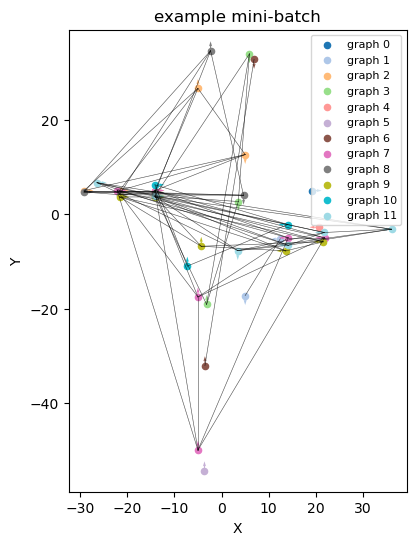

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric.data import Batch

def visualize_pyg_batch(batch: Batch,
                        xy_index=(0, 1),        # which columns in x are X,Y
                        yaw_index=3,            # which column is yaw (rad)
                        show_edges=True,
                        figsize=(6, 6),
                        title=None):
    """
    Plot all graphs contained in a PyG Batch.

    Args
    ----
    batch : torch_geometric.data.Batch
        The mini‑batch from your DataLoader.
    xy_index : tuple
        Indices of x- and y‑columns inside `batch.x` tensor.
    yaw_index : int
        Index of the yaw column in `batch.x` (radians).  Set to None to skip arrows.
    show_edges : bool
        Draw edge lines if True.
    """
    # -------- decode node positions ----------
    x_col, y_col = xy_index
    xs = batch.x[:, x_col].cpu().numpy()
    ys = batch.x[:, y_col].cpu().numpy()

    # one colour per graph in the batch
    graph_ids = batch.batch.cpu().numpy()           # 0 … (num_graphs-1)
    num_graphs = graph_ids.max() + 1
    cmap = plt.cm.get_cmap('tab20', num_graphs)

    # -------- start figure ----------
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_aspect('equal')

    # -------- plot each graph ----------
    for gid in range(num_graphs):
        mask = graph_ids == gid
        ax.scatter(xs[mask], ys[mask],
                   s=20, color=cmap(gid), label=f'graph {gid}')

        # optional arrows (yaw)
        if yaw_index is not None:
            yaws = batch.x[mask, yaw_index].cpu().numpy()
            arrow_dx = np.cos(yaws) * 2.0   # length scale = 2 m
            arrow_dy = np.sin(yaws) * 2.0
            ax.quiver(xs[mask], ys[mask],
                      arrow_dx, arrow_dy,
                      angles='xy', scale_units='xy', scale=1,
                      color=cmap(gid), width=0.003)

    # -------- edges ----------
    if show_edges and batch.edge_index.numel() > 0:
        ei = batch.edge_index.cpu().numpy()
        for src, dst in ei.T:
            gx, gy = xs[src], ys[src]
            dx, dy = xs[dst], ys[dst]
            ax.plot([gx, dx], [gy, dy],
                    color='k', linewidth=0.4, alpha=0.4)

    ax.set_xlabel('X'); ax.set_ylabel('Y')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Batch with {num_graphs} graphs | {xs.shape[0]} nodes')
    ax.legend(loc='upper right', fontsize=8)
    plt.show()

batch = next(iter(dataloader))
visualize_pyg_batch(batch,      # default columns X,Y = (0,1), yaw = 3
                    title='example mini‑batch')

## Visualize pkl data with the future steps

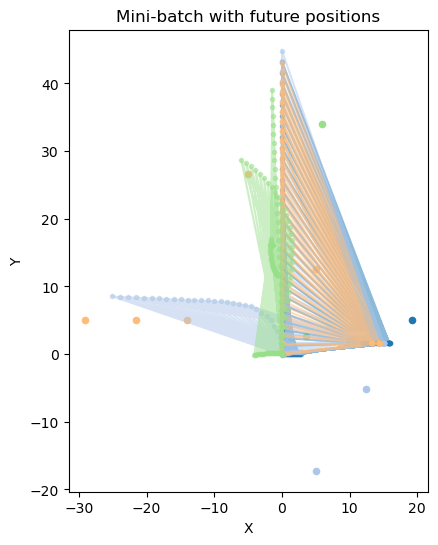

In [5]:
def visualize_pyg_batch_with_future(batch: Batch,
                                   xy_index=(0, 1),
                                   future_dim=180,   # total future coordinates per car (e.g., 90 steps × 2)
                                   num_cars=None,    # number of cars to plot (None = all)
                                   figsize=(6, 6),
                                   title=None):
    x_col, y_col = xy_index
    xs = batch.x[:, x_col].cpu().numpy()
    ys = batch.x[:, y_col].cpu().numpy()

    graph_ids = batch.batch.cpu().numpy()
    num_graphs = graph_ids.max() + 1
    cmap = plt.cm.get_cmap('tab20', num_graphs)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_aspect('equal')

    # Select indices to plot
    indices = np.arange(xs.shape[0])
    if num_cars is not None:
        indices = indices[:num_cars]

    for gid in range(num_graphs):
        mask = (graph_ids == gid) & np.isin(np.arange(xs.shape[0]), indices)
        ax.scatter(xs[mask], ys[mask], s=20, color=cmap(gid), label=f'graph {gid}')

        # Plot future positions for each node in this graph (no connection to initial point)
        for idx in np.where(mask)[0]:
            future = batch.y[idx].cpu().numpy()
            future_xy = future.reshape(-1, 2)  # shape: [num_steps, 2]
            ax.plot(future_xy[:, 0], future_xy[:, 1], 'o-', color=cmap(gid), alpha=0.5, markersize=3)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Batch with {num_graphs} graphs | {xs.shape[0]} nodes')
    # ax.legend(loc='upper right', fontsize=8)
    plt.show()

visualize_pyg_batch_with_future(batch, xy_index=(0, 1), future_dim=batch.y.shape[1], num_cars=10, title='Mini-batch with future positions')


In [6]:
batch

DataBatch(x=[41, 7], edge_index=[2, 183], y=[41, 180], t=[12], weights=[41], batch=[41], ptr=[13])

In [7]:
i = 11
batch[i].x, batch[i].edge_index.shape, batch[i].y.shape

(tensor([[  3.4251,  -7.7100,  14.6700,  -1.5708,   0.0000,   1.0000,   0.0000],
         [-26.3500,   6.6719,   3.6400,   0.0000,   0.0000,   1.0000,   0.0000],
         [-14.1000,   3.7690,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000],
         [ 14.1000,  -6.5766,   0.0000,   3.1416,   0.0000,   1.0000,   0.0000],
         [ 21.7300,  -3.8748,   0.1400,   3.1416,   0.0000,   1.0000,   0.0000],
         [ 35.9900,  -3.1801,   4.7500,   3.1416,   0.0000,   1.0000,   0.0000]]),
 torch.Size([2, 36]),
 torch.Size([6, 180]))

In [8]:
batch[0].y.shape

torch.Size([1, 180])

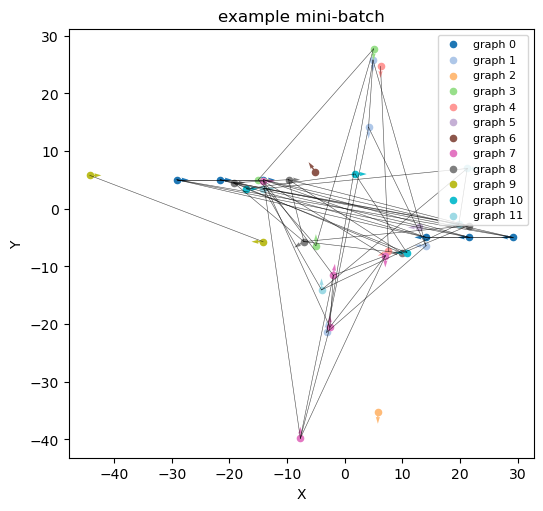

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric.data import Batch

def visualize_pyg_batch(batch: Batch,
                        xy_index=(0, 1),        # which columns in x are X,Y
                        yaw_index=3,            # which column is yaw (rad)
                        show_edges=True,
                        figsize=(6, 6),
                        title=None):
    """
    Plot all graphs contained in a PyG Batch.

    Args
    ----
    batch : torch_geometric.data.Batch
        The mini‑batch from your DataLoader.
    xy_index : tuple
        Indices of x- and y‑columns inside `batch.x` tensor.
    yaw_index : int
        Index of the yaw column in `batch.x` (radians).  Set to None to skip arrows.
    show_edges : bool
        Draw edge lines if True.
    """
    # -------- decode node positions ----------
    x_col, y_col = xy_index
    xs = batch.x[:, x_col].cpu().numpy()
    ys = batch.x[:, y_col].cpu().numpy()

    # one colour per graph in the batch
    graph_ids = batch.batch.cpu().numpy()           # 0 … (num_graphs-1)
    num_graphs = graph_ids.max() + 1
    cmap = plt.cm.get_cmap('tab20', num_graphs)

    # -------- start figure ----------
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_aspect('equal')

    # -------- plot each graph ----------
    for gid in range(num_graphs):
        mask = graph_ids == gid
        ax.scatter(xs[mask], ys[mask],
                   s=20, color=cmap(gid), label=f'graph {gid}')

        # optional arrows (yaw)
        if yaw_index is not None:
            yaws = batch.x[mask, yaw_index].cpu().numpy()
            arrow_dx = np.cos(yaws) * 2.0   # length scale = 2 m
            arrow_dy = np.sin(yaws) * 2.0
            ax.quiver(xs[mask], ys[mask],
                      arrow_dx, arrow_dy,
                      angles='xy', scale_units='xy', scale=1,
                      color=cmap(gid), width=0.003)

    # -------- edges ----------
    if show_edges and batch.edge_index.numel() > 0:
        ei = batch.edge_index.cpu().numpy()
        for src, dst in ei.T:
            gx, gy = xs[src], ys[src]
            dx, dy = xs[dst], ys[dst]
            ax.plot([gx, dx], [gy, dy],
                    color='k', linewidth=0.4, alpha=0.4)

    ax.set_xlabel('X'); ax.set_ylabel('Y')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Batch with {num_graphs} graphs | {xs.shape[0]} nodes')
    ax.legend(loc='upper right', fontsize=8)
    plt.show()

batch = next(iter(dataloader))
visualize_pyg_batch(batch,      # default columns X,Y = (0,1), yaw = 3
                    title='example mini‑batch')

In [10]:
import os
import datetime
from pathlib import Path

import numpy as np
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

# Make sure these are imported from your project
from dataset import CarDataset 
from utils.config import PRED_LEN

# --- Helper function for coordinate transformation (copied from dataset.py) ---
def rotation_matrix(yaw):
    """
    Creates a rotation matrix to align the yaw direction with the +y axis.
    This is the forward transformation used in preprocessing.
    """
    # Note: The original rotation is to align with +y, which means rotating by (pi/2 - yaw)
    angle = np.pi/2 - yaw
    rotation = np.array([[np.cos(angle), -np.sin(angle)],
                         [np.sin(angle), np.cos(angle)]])
    return rotation

# --- Function to plot batch animations ---
def plot_batch_animation(batch, pred_len, save_dir='visualizations'):
    """
    Visualizes a batch of trajectory data by creating an animation for each scene.

    Args:
        batch: A single batch object from a PyTorch Geometric DataLoader.
        pred_len (int): The length of the prediction horizon.
        save_dir (str): Directory to save the output MP4 files.
    """
    # Ensure the save directory exists
    Path(save_dir).mkdir(exist_ok=True)

    # De-batch into a list of individual graphs
    num_graphs_in_batch = batch.num_graphs
    print(f"Processing batch with {num_graphs_in_batch} scenes...")

    # Use tqdm for a progress bar over the scenes in the batch
    for i in tqdm(range(num_graphs_in_batch), desc="Generating animations"):
        # Create a boolean mask to select nodes (vehicles) for the current scene
        mask = (batch.batch == i)
        
        # --- 1. Extract Data for the Current Scene ---
        # Initial states: [num_vehicles, 7] -> [x, y, speed, yaw, intent...]
        scene_x = batch.x[mask].detach().cpu().numpy()
        # Ground truth future states (flattened): [num_vehicles, pred_len * 6]
        scene_y = batch.y[mask].detach().cpu().numpy()

        num_vehicles = scene_x.shape[0]
        if num_vehicles == 0:
            continue

        # --- 2. Reshape and Reverse Coordinate Transformation ---
        # Reshape y to [num_vehicles, pred_len, 6] -> [x, y, v, yaw, acc, delta]
        local_trajs = scene_y.reshape(num_vehicles, pred_len, 6)
        
        # Extract local (x, y) trajectories and initial global states
        local_trajs_xy = local_trajs[:, :, :2] # Shape: [num_vehicles, pred_len, 2]
        initial_pos = scene_x[:, :2]           # Shape: [num_vehicles, 2]
        initial_yaws = scene_x[:, 3]           # Shape: [num_vehicles]
        
        # Reconstruct the absolute trajectories in the global coordinate frame
        global_abs_trajs = np.zeros_like(local_trajs_xy)
        for v_idx in range(num_vehicles):
            # Get the forward rotation matrix
            R = rotation_matrix(initial_yaws[v_idx])
            # Inverse rotation is the transpose
            inv_R = R.T
            
            # Apply inverse rotation to each point in the local trajectory
            # (inv_R @ local_point.T).T gives the rotated point
            global_relative_traj = (inv_R @ local_trajs_xy[v_idx].T).T
            
            # Add the initial position to get the absolute trajectory
            global_abs_trajs[v_idx] = global_relative_traj + initial_pos[v_idx]

        # --- 3. Create the Animation ---
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Find bounds for the plot
        all_x = np.concatenate([initial_pos[:, 0], global_abs_trajs[:, :, 0].flatten()])
        all_y = np.concatenate([initial_pos[:, 1], global_abs_trajs[:, :, 1].flatten()])
        ax.set_xlim(all_x.min() - 10, all_x.max() + 10)
        ax.set_ylim(all_y.min() - 10, all_y.max() + 10)
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f'Scene {i} from Batch')
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
        ax.grid(True)

        # Plot initial positions as solid circles
        ax.scatter(initial_pos[:, 0], initial_pos[:, 1], c='blue', s=50, zorder=3, label='Initial Position')

        # Create line objects for each vehicle's trajectory
        lines = [ax.plot([], [], lw=2, c='red')[0] for _ in range(num_vehicles)]
        
        # Create point objects for the current position of each vehicle
        points = [ax.plot([], [], marker='o', c='orange', markersize=6)[0] for _ in range(num_vehicles)]

        def init():
            for line, point in zip(lines, points):
                line.set_data([], [])
                point.set_data([], [])
            return lines + points

        def animate(t):
            # t is the frame number, from 0 to pred_len-1
            for v_idx, (line, point) in enumerate(zip(lines, points)):
                # Draw trajectory up to frame t
                traj_so_far = global_abs_trajs[v_idx, :t+1]
                line.set_data(traj_so_far[:, 0], traj_so_far[:, 1])

                # Draw a point at the current position
                current_pos = global_abs_trajs[v_idx, t]
                point.set_data(current_pos[0], current_pos[1])

            ax.set_title(f'Scene {i} - Timestep {t+1}/{pred_len}')
            return lines + points

        # Create and save the animation
        ani = animation.FuncAnimation(fig, animate, frames=pred_len,
                                      init_func=init, blit=True, interval=100) # interval in ms

        # Save the file
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(save_dir, f'scene_{i}_{timestamp}.mp4')
        ani.save(save_path, writer='ffmpeg', fps=10)
        plt.close(fig) # Close the figure to free up memory

if __name__ == '__main__':
    # --- Configuration ---
    batch_size = 4  # Use a smaller batch size for visualization
    val_folder = 'csv/train_pre_1k_simple_separate_10m'  # Your dataset folder
    pred_len = 30  # Get prediction length from your config

    # --- Dataset and DataLoader ---
    print(f"Loading dataset from: {val_folder}")
    # Set mpc_aug=True/False depending on which data you want to see
    dataset = CarDataset(preprocess_folder=val_folder, mpc_aug=True, mlp=False)
    
    # shuffle=False makes it easier to repeatedly visualize the same scenes
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # --- Fetch a single batch and plot it ---
    print("Fetching one batch from the dataloader...")
    for _ in range(5):
        first_batch = next(iter(dataloader))
        # Call the visualization function
        plot_batch_animation(first_batch, pred_len=pred_len, save_dir='batch_visualizations')
        print(f"\nDone! Animations saved in 'batch_visualizations' folder.")


Loading dataset from: csv/train_pre_1k_simple_separate_10m
Fetching one batch from the dataloader...
Processing batch with 4 scenes...


Generating animations:   0%|          | 0/4 [00:00<?, ?it/s]

Generating animations: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]



Done! Animations saved in 'batch_visualizations' folder.
Processing batch with 4 scenes...


Generating animations: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]



Done! Animations saved in 'batch_visualizations' folder.
Processing batch with 4 scenes...


Generating animations: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]



Done! Animations saved in 'batch_visualizations' folder.
Processing batch with 4 scenes...


Generating animations: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]



Done! Animations saved in 'batch_visualizations' folder.
Processing batch with 4 scenes...


Generating animations: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Done! Animations saved in 'batch_visualizations' folder.


In [ ]:
# --- Model ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = 'trained_params/debugging/20250720_141527_simple_separate_10m/model_transformer_best.pth'
model = GNN_mtl_gnn(hidden_channels=128).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()